In [1]:
import mpramnist
from mpramnist.Evfratov.dataset import EvfratovDataset

from mpramnist.models import HumanLegNet
from mpramnist.models import initialize_weights
from mpramnist.trainers import LitModel_Evfratov

import mpramnist.transforms as t
import mpramnist.target_transforms as t_t

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import lightning.pytorch as L
import torch.nn.functional as F

In [2]:
BATCH_SIZE = 32
NUM_WORKERS = 103

## Some info

The dataset has a pair of attributes:

**merge_last_classes** — determines whether the last two classes should be merged into one.

**length_of_seq** — determines which dataset to use. "23" refers to the dataset with sequences of length 23, and "33" refers to the dataset with sequences of length 33. The default is "23".


## Define set of transforms

In [3]:
# preprocessing
train_transform = t.Compose([
    t.Seq2Tensor(),
    t.ReverseComplement(0.5),
])

test_transform = t.Compose([ # test transform has probability of reverse-complement = 0.
    t.Seq2Tensor(), 
    t.ReverseComplement(0), # Reverse complementary transformation for all sequences with a probability of 0
])

## Merging last 2 classes

### 8 classes

The data initially has 8 labels. 

You can train the model on all 8 classes, but the number of instances in the last class is extremely small. 

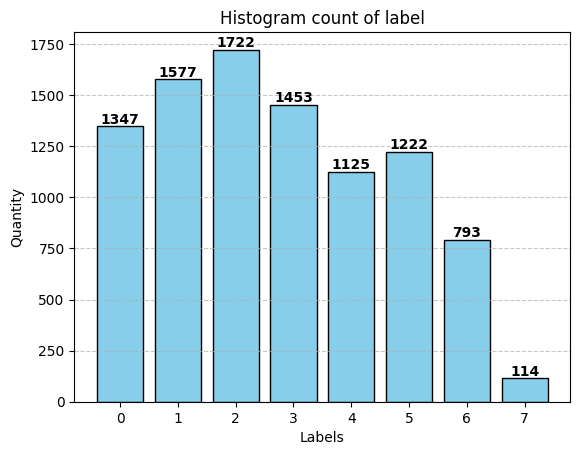

In [4]:
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                                length_of_seq = 23, # or 33
                                transform=train_transform, root = "../data/") # use "train" for default training set
# Plot histogram with 8 classes
train_dataset.hist_plot()

# too few examples in group 8

Therefore, to balance class representation, we propose merging the last two classes into one.

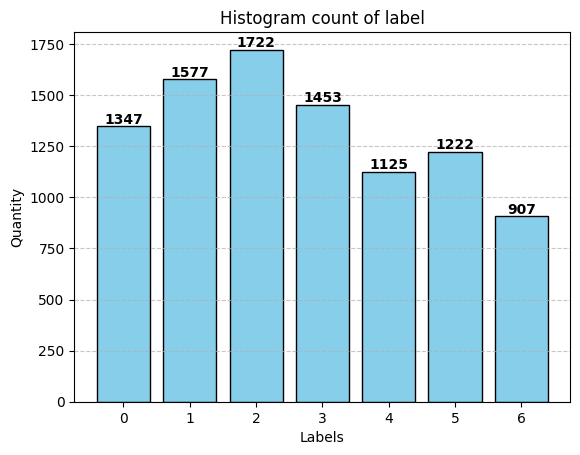

In [5]:
merge_last_classes = True

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                                length_of_seq = 23, # or 33
                                transform=train_transform, root = "../data/") # use "train" for default training set
# Plot histogram with 7 classes
train_dataset.hist_plot()

# looks better

## First, Lets work with sequences length of 23

In [6]:
length_of_seq = 23
merge_last_classes = True

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes,
                                length_of_seq = length_of_seq,
                                transform=train_transform, root = "../data/") # use "train" for default training set

val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                              length_of_seq = length_of_seq,
                              transform=test_transform, root = "../data/") # use "val" for default validation set 

test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                               length_of_seq = length_of_seq,
                               transform=test_transform, root = "../data/") # use "test" for default test set

In [7]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [8]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset EvfratovDataset of size 9353 (MpraDaraset)
    Number of datapoints: 9353
    Used split fold: train
Dataset EvfratovDataset of size 1169 (MpraDaraset)
    Number of datapoints: 1169
    Used split fold: val
Dataset EvfratovDataset of size 1170 (MpraDaraset)
    Number of datapoints: 1170
    Used split fold: test


In [9]:
# Use train_dataset.n_classes to define number of used classes
N_CLASSES = train_dataset.n_classes
in_channels = len(train_dataset[0][0])

In [10]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = N_CLASSES,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Evfratov(model = model,
                           loss = nn.CrossEntropyLoss(),
                           n_classes = N_CLASSES,
                           weight_decay = 1e-1, lr = 1e-2, print_each = 10)

In [11]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.40290847420692444 | Val AUROC: 0.840363621711731 | Val AUPR: 0.45793160796165466 |
| Val Precision: 0.4597620666027069 | Val Recall: 0.3930922746658325 | Val F1: 0.39470499753952026 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 19 | Val Acc: 0.4294268488883972 | Val AUROC: 0.8413217067718506 | Val AUPR: 0.4657658338546753 |
| Val Precision: 0.4287109375 | Val Recall: 0.42498642206192017 | Val F1: 0.41312795877456665 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 29 | Val Acc: 0.4644995629787445 | Val AUROC: 0.860131561756134 | Val AUPR: 0.49529126286506653 |
| Val Precision: 0.5028933882713318 | Val Recall: 0.45390191674232483 | Val F1: 0.45724359154701233 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 39 | Val Acc: 0.5072711706161499 | Val AUROC: 0.8772362470626831 | Val AUPR: 0.5428900718688965 |
| Val Precision: 0.5385832190513611 | Val Recall: 0.516889214515686 | Val F1: 0.520840048789978 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Acc: 0.49786141514778137 | Val AUROC: 0.86415034532547 | Val AUPR: 0.5190927982330322 |
| Val Precision: 0.5251144170761108 | Val Recall: 0.5076167583465576 | Val F1: 0.5146824717521667 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.49059829115867615 | Test AUROC: 0.8607160449028015 | Test AUPR: 0.5126579999923706 |
| Test Precision: 0.5126562714576721 | Test Recall: 0.5028774738311768 | Test F1: 0.5070900321006775 
----------------------------------------------------------------------------------------------------



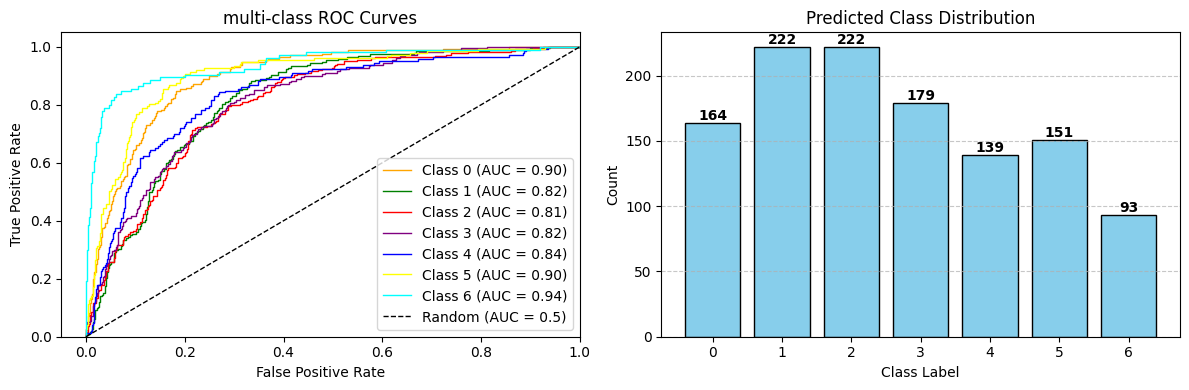

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.5023181438446045
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5023181438446045}]

In [12]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)
trainer.test(seq_model, dataloaders = test_loader)

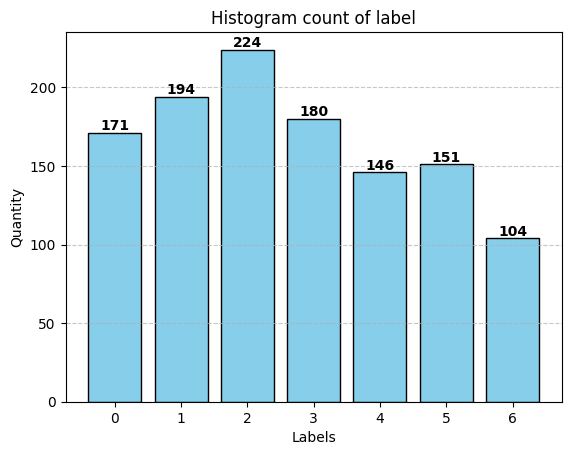

In [13]:
# To see real number of examples in class - plot histogram on test dataset
test_dataset.hist_plot()

## Second, Lets try with sequences length of 33

In [14]:
length_of_seq = 33
merge_last_classes = False

train_dataset = EvfratovDataset(split="train", merge_last_classes = merge_last_classes, 
                                length_of_seq = length_of_seq, # now 33
                                transform=train_transform, root = "../data/") 
val_dataset = EvfratovDataset(split="val", merge_last_classes = merge_last_classes,
                              length_of_seq = length_of_seq,
                              transform=test_transform, root = "../data/") 
test_dataset = EvfratovDataset(split="test", merge_last_classes = merge_last_classes,
                               length_of_seq = length_of_seq,
                               transform=test_transform, root = "../data/") 

In [15]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

In [16]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset EvfratovDataset of size 9511 (MpraDaraset)
    Number of datapoints: 9511
    Used split fold: train
Dataset EvfratovDataset of size 1189 (MpraDaraset)
    Number of datapoints: 1189
    Used split fold: val
Dataset EvfratovDataset of size 1189 (MpraDaraset)
    Number of datapoints: 1189
    Used split fold: test


In [17]:
# Use train_dataset.n_classes to define number of used classes
N_CLASSES = train_dataset.n_classes
in_channels = len(train_dataset[0][0])

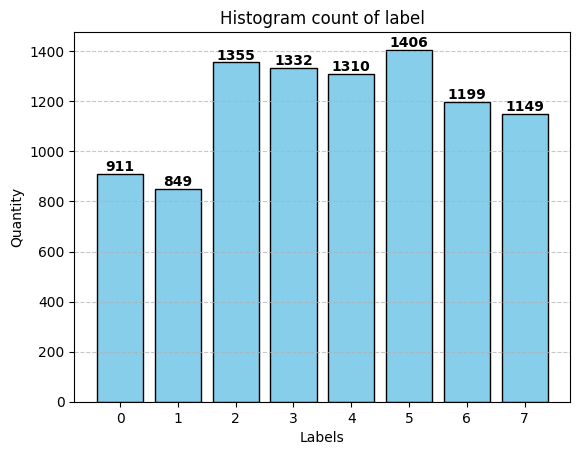

In [18]:
train_dataset.hist_plot()

# good enough, so let's leave merge_last_classes = False

In [19]:
model = HumanLegNet(in_ch=in_channels,
                     output_dim = N_CLASSES,
                     stem_ch=64,
                     stem_ks=11,
                     ef_ks=9,
                     ef_block_sizes=[80, 96, 112, 128],
                     pool_sizes=[2,2,2,2],
                     resize_factor=4)
model.apply(initialize_weights)

seq_model = LitModel_Evfratov(model = model,
                           loss = nn.CrossEntropyLoss(),
                           n_classes = N_CLASSES,
                           weight_decay = 1e-2, lr = 1e-2, print_each = 10)

In [20]:
# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=50,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = True,
    num_sanity_val_steps=0,
    enable_model_summary=False
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nios/miniconda3/envs/mpramnist/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)


Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 9 | Val Acc: 0.3835155665874481 | Val AUROC: 0.8206959962844849 | Val AUPR: 0.3886526823043823 |
| Val Precision: 0.34887951612472534 | Val Recall: 0.3789692521095276 | Val F1: 0.3441186845302582 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 19 | Val Acc: 0.43818333745002747 | Val AUROC: 0.843069314956665 | Val AUPR: 0.4339326024055481 |
| Val Precision: 0.4310954809188843 | Val Recall: 0.43127965927124023 | Val F1: 0.4210408627986908 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 29 | Val Acc: 0.403700590133667 | Val AUROC: 0.8213690519332886 | Val AUPR: 0.3992413878440857 |
| Val Precision: 0.4243294596672058 | Val Recall: 0.4009603261947632 | Val F1: 0.40881603956222534 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Epoch: 39 | Val Acc: 0.40285953879356384 | Val AUROC: 0.8040070533752441 | Val AUPR: 0.3836653232574463 |
| Val Precision: 0.45163825154304504 | Val Recall: 0.3996501863002777 | Val F1: 0.41043293476104736 
----------------------------------------------------------------------------------------------------



Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=50` reached.



----------------------------------------------------------------------------------------------------
| Epoch: 49 | Val Acc: 0.3910849392414093 | Val AUROC: 0.7936842441558838 | Val AUPR: 0.37178897857666016 |
| Val Precision: 0.4341859221458435 | Val Recall: 0.3901188373565674 | Val F1: 0.4002602696418762 
----------------------------------------------------------------------------------------------------



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                        | 0/? [00:00…


----------------------------------------------------------------------------------------------------
| Test Acc: 0.4053826630115509 | Test AUROC: 0.7933567762374878 | Test AUPR: 0.37298575043678284 |
| Test Precision: 0.44104284048080444 | Test Recall: 0.4014114737510681 | Test F1: 0.41070544719696045 
----------------------------------------------------------------------------------------------------



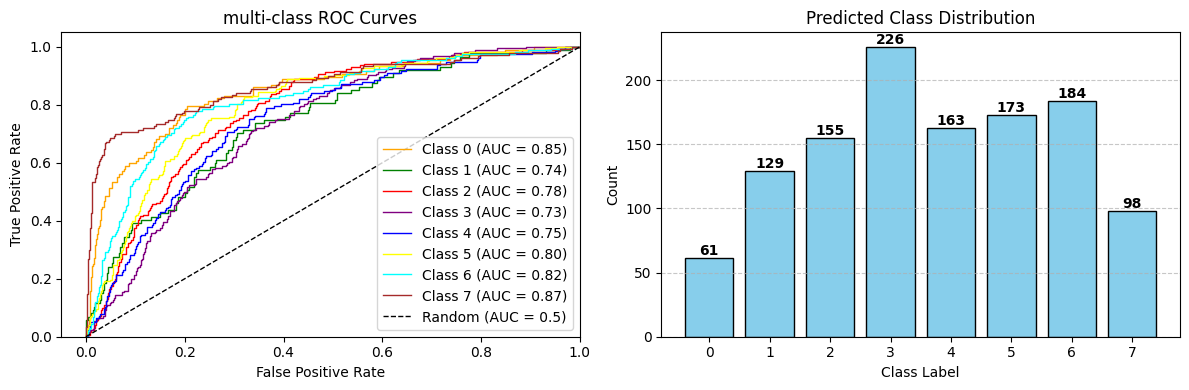

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            4.375471115112305
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 4.375471115112305}]

In [21]:
# Train the model
trainer.fit(seq_model,
            train_dataloaders = train_loader,
            val_dataloaders = val_loader)
trainer.test(seq_model, dataloaders = test_loader)

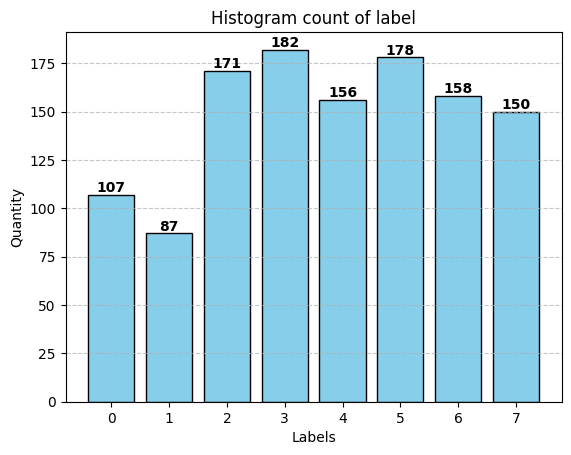

In [22]:
# To see real number of examples in class - plot histogram on test dataset
test_dataset.hist_plot()